## Strings Project 

Some boundry conditions to consider is that the fixed end has 0 displacement, the free end has velocity zero, because the string will be horizontal at the end 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ode
from scipy.optimize import curve_fit
from vpython import * #yes, I know I'm not supposed to do this. Sorry.
from scipy.linalg import eigh

from mplEasyAnimate import animation
from tqdm import tqdm

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
#Psedo code:: how are you going to solve the problem at hand. 
#Fixed at one hand, free on the other. 
#Boundry condtion, fixed end is displacement == o, free hand would still be small verticle displacement vs. the legnth. 
#Boundry condition:: fixed end:: Displacement == 0;  free end:: (du/dx)--> velocity == 0 because the strong is flat(horiz.) at
#                        every height that the string encounters. 
#
#
#

#### This sets up the normal mode calcuations for the string

In [3]:
def normal_modes(Natoms, ks, mass, ui, udoti, t_total):
    global N, k, m
    N=Natoms
    k=ks
    m=mass
    
    #Build matrices
    A=np.zeros((Natoms,Natoms))

    for i in range(Natoms):
        A[i,i] = 2*ks
        if i==0:
            A[0,i+1]=-ks
        elif i==Natoms-1:
            A[i,i-1]=-ks
        else:
            A[i,i-1]= -ks
            A[i,i+1]= -ks
        
    A[Natoms-1, Natoms-1] = ks

    B=mass*np.identity(Natoms)   

    #find eigenvalues and eigenvectors
    lamb, a = eigh(A, B)        # eigenvalues and eigenvectors  
   
    #Find coefficients for normal modes
    Acoeffs = np.linalg.solve(a,ui)

    #build the general solution
    t = np.linspace(0,t_total,1000)

    omegas = np.sqrt(lamb)
    u_atoms = np.zeros((Natoms,len(t)))

    for i in range(Natoms):
        for w in range(0,len(omegas)):
            u_atoms[i] = u_atoms[i] + Acoeffs[w]*a[i,w]*np.cos(omegas[w]*t)

    return omegas, a, u_atoms, t

#### This is the plotting for each mode

In [4]:
def plot_mode_teq0(mode, freqs, vecs): #plot normal mode at t=0
    
    u_mode = vecs[:,mode]
    u_mode_with_boundary=np.insert(u_mode,0,0) #add 0 to beginning of array
    u_mode_with_boundary=np.append(u_mode_with_boundary, u_mode[-1]) #add 0 to end of array
    xa = np.linspace(0,L,Natoms+2)
        
    plt.figure()
    plt.title("normal mode %d" % mode)
    plt.plot(xa,u_mode_with_boundary, 'b-', label='u_i')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend(loc='lower right')
    plt.show()

These are some inital conditions and other variables that are directly defined, the lower half calculates the Eigenvectors 

In [5]:
Natoms = 100
ks = 1
mass = 1
L = 1
L0 = L/(Natoms+1)
F_T = ks*L0
t_total = 10*np.pi

u_i = np.zeros(Natoms)
udot_i = np.zeros(Natoms)

eig_freq, eig_vec, u, ta = normal_modes(Natoms, ks, mass, u_i, udot_i, t_total)

In [6]:
m1=m2=m3 = m  #setting the mass of all items on the string. 

A = np.array([[ks, -ks, 0], [-ks, 2*ks, -ks], [0, -ks, ks]])
B = np.array([[m1, 0, 0], [0, m2, 0], [0, 0, m3]])

lamb, a = eigh(A, B)        # eigenvalues and eigenvectors  
print("The eigenvalues are (omega^2):\n", lamb, '\n')

print("The eigenvectors are column vectors in:\n", a)

The eigenvalues are (omega^2):
 [9.99658224e-17 1.00000000e+00 3.00000000e+00] 

The eigenvectors are column vectors in:
 [[-5.77350269e-01 -7.07106781e-01  4.08248290e-01]
 [-5.77350269e-01  7.58447699e-17 -8.16496581e-01]
 [-5.77350269e-01  7.07106781e-01  4.08248290e-01]]


#### Below are the normal modes, plotted

Mode 0


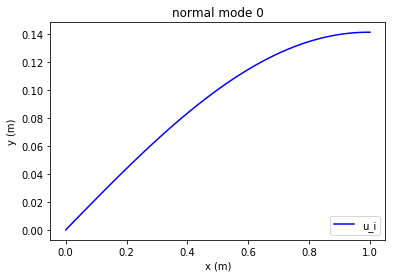

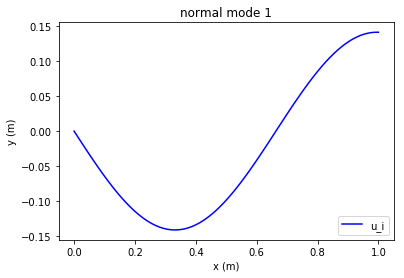

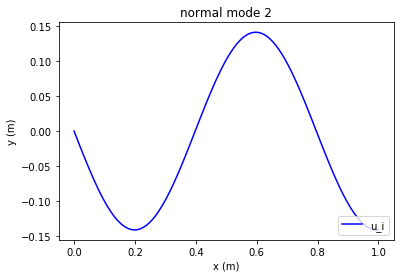

In [7]:
print("Mode 0")
plot_mode_teq0(0,eig_freq,eig_vec)
plot_mode_teq0(1,eig_freq,eig_vec)
plot_mode_teq0(2,eig_freq,eig_vec)

In [8]:
def animate_mode(mode, freqs, vecs):
    scene=canvas()
    
    a = vecs[:,mode]
    omega = freqs[mode]
    
    scene.background=color.white
    
    balls=[]
    xballs = np.linspace(-L/2+L0,L/2-L0,Natoms)
    
    springs=[]
    xsprings = np.linspace(-L/2,L/2-L0,Natoms+1)
    springs.append(helix(pos=vec(-L/2,0,0), axis=vec(L0,0,0), color=color.orange, radius=L0/8))
    
    for x in xballs:
        ball = sphere(pos=vec(x,0,0), radius=L0/4, color=color.red)
        balls.append(ball)
        spring = helix(pos=ball.pos, axis=vec(L0,0,0), color=color.orange, radius=ball.radius/2)
        springs.append(spring)
        
    #set initial positions    
    for i in range(0,len(balls)):
        ball = balls[i]
        u_t = a[i]
        ball.pos.y = u_t
    for i in range(1, len(springs)-1): #all springs except first and last
        spring = springs[i]
        spring.pos=balls[i-1].pos
        spring.axis=balls[i].pos-spring.pos
    #update first and last springs
    springs[0].axis = balls[0].pos-springs[0].pos
    springs[-1].pos = balls[-1].pos
    springs[-1].axis = vec(L/2,0,0)-springs[-1].pos
    
    scene.waitfor("click")
    t=0
    dt=0.01

    while t<10*t_total:
        rate(1000)
        for i in range(0,len(balls)):
            ball = balls[i]
            u_t = a[i]*np.cos(omega*t)
            ball.pos.y = u_t
        for i in range(1, len(springs)-1): #all springs except first and last
            spring = springs[i]
            spring.pos=balls[i-1].pos
            spring.axis=balls[i].pos-spring.pos
        #update first and last springs
        springs[0].axis = balls[0].pos-springs[0].pos
        springs[-1].pos = balls[-1].pos
        springs[-1].axis = vec(L/2,0,0)-springs[-1].pos

        t=t+dt
                

In [ ]:
animate_mode(2,eig_freq,eig_vec)

<IPython.core.display.Javascript object>

## This sets up the easy animate

In [9]:
from IPython.display import HTML

def playVideo(path):
    return HTML("""
                <video width="320" height="240" controls>
                  <source src="{}" type="video/mp4">
                </video>
                """.format(path))

In [10]:
def easyanimate_string(t_array, u_array, filename):
    xa = np.linspace(0., L, N+1)

    t_offsets = t_array
    anim = animation(filename)
    i=0
    for offset in tqdm(t_offsets):
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        ax.plot(xa, u_array[i,:])
        ax.set_xlim(0,L)
        ax.set_ylim(-1.1,1.1)
        
        anim.add_frame(fig)
        plt.close(fig)
        i=i+1
    anim.close()    

ERROR! Session/line number was not unique in database. History logging moved to new session 370


Rather than looking at a string that was loose on one end as the one above, I decided to look at the wave motion of a string that is already vibrating to be plucked. For example, a guitar string would be plucked after it was already pucked and it still vibrating. 

In [11]:
def wavemotion(u0, u1):
    u2 = 2*(1-b)*u1 - u0                      
    u2[1:-1] += b*( u1[0:-2] + u1[2:] )  

    return u2

def gaussian(x):
    return np.exp(-(x-5)**2)  

def sinusoidal(x,A,k):
    return A*np.sin(k*x)

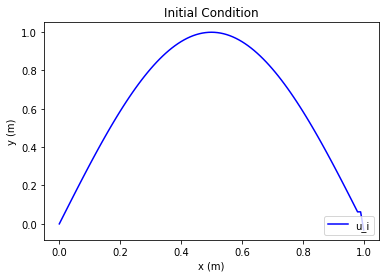

In [12]:
b = 1.0                    # beta^2
h = L/Natoms


N_t = 200 #number of time intervals
dt = t_total/N_t
t = 0
ta = np.linspace(0,t_total,N_t+1)

A = 0.5
lamb = 2*L
v = b*h/dt
f = v/lamb
k=2*np.pi/lamb

x = np.linspace(0, L, Natoms+1)
u0 = 2*sinusoidal(x,A,k)
u1 = sinusoidal(x-v*dt,A,k)+sinusoidal(x+v*dt,A,k)

data = np.zeros((N_t+1,Natoms+1))  #columns are u at grid points
data[0]=u0
data[1]=u1

u0[-1] = u0[-2]
u1[-1] = u1[-2]
for i in range(N_t):
    u2 = wavemotion(u0, u1)
    u0, u1 = u1, u2
    data[i]=u2

data.shape

plt.figure()
plt.title("Initial Condition")
plt.plot(x,data[0,:], 'b-', label='u_i')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend(loc='lower right')
plt.show()


In [13]:
file='string-3.mp4'
easyanimate_string(ta,data,file)

100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [00:48<00:00,  4.15it/s]


In [14]:
playVideo(file)

Giving credit:

1. Dr. Aaron Titus, High Point University Physics Department
2. Jay Wang, Author of Computational Modeling (and visualization of physical systems with Python)